# NB: Pandas and SQL

# Overview

In this exercise, we split the raw table into tables corresponding the **implied subjects** we discovered. 

Then we use joins to reassemble the data. 

We will assumed that the implied subjects are ARTIST, GENRE, ALBUM, and REVIEW.

To do this, we use Pandas to store the initial table as a dataframe, and then we create variations of that dataframe and save those to the database as new tables. 

# Connect to the database

In [1]:
import sqlite3
import pandas as pd
import numpy as np

We create an empty database to store our work.

In [2]:
db = sqlite3.connect('./data/pitchfork.db')

# Get the raw review table

Get the review data.

In [3]:
raw = pd.read_csv("./data/pitchfork.csv").set_index('id')

In [4]:
raw

,album,artist,best,date,genre,review,score
id,,,,,,,
1,A.M./Being There,Wilco,1,December 6 2017,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
2,No Shame,Hopsin,0,December 6 2017,Rap,"On his corrosive fifth album, the rapper takes...",3.5
3,Material Control,Glassjaw,0,December 6 2017,Rock,"On their first album in 15 years, the Long Isl...",6.6
4,Weighing of the Heart,Nabihah Iqbal,0,December 6 2017,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7
5,The Visitor,Neil Young / Promise of the Real,0,December 5 2017,Rock,"While still pointedly political, Neil Youngís ...",6.7
...,...,...,...,...,...,...,...
19551,1999,Cassius,0,January 26 1999,Electronic,"Well, it's been two weeks now, and I guess it'...",4.8
19552,Let Us Replay!,Coldcut,0,January 26 1999,Electronic,The marketing guys of yer average modern megac...,8.9
19553,"Singles Breaking Up, Vol. 1",Don Caballero,0,January 12 1999,Experimental,"Well, kids, I just went back and re-read my re...",7.2


# Remove rows with missing data

Here's a quick to inventory which columns have missing data.

In [5]:
raw.isna().sum()

album     5
artist    0
best      0
date      0
genre     0
review    1
score     0
dtype: int64

In [6]:
raw[raw.album.isna()]

,album,artist,best,date,genre,review,score
id,,,,,,,
58,NaN,Gord Downie,0,November 17 2017,Rock,Recorded in his final months and released 10 d...,7.4
261,NaN,Yves Tumor,0,September 23 2017,Experimental,This self-released compilation from Yves Tumor...,7.8
273,NaN,Lee Ranaldo,0,September 20 2017,Experimental,Lee Ranaldoís latest album is his finest post-...,6.5
351,NaN,Queens of the Stone Age,0,August 28 2017,Rock,"With production flourishes from Mark Ronson, J...",6.9
6795,NaN,Inverloch,0,April 9 2012,None,The Melbourne metal band forges a strong bridg...,6.7


In [7]:
raw[raw.review.isna()]

,album,artist,best,date,genre,review,score
id,,,,,,,
13301,Shine On,Jet,0,October 2 2006,Rock,NaN,0.0


In [8]:
raw = raw.dropna()

Drop dupicate rows, too.

In [9]:
raw = raw.drop_duplicates()

In [10]:
raw = raw.reset_index().set_index('id')

In [11]:
raw.to_sql('raw', db, if_exists='replace')

19544

In [31]:
raw

,album,artist,best,date,genre,review,score
id,,,,,,,
1,A.M./Being There,Wilco,1,December 6 2017,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
2,No Shame,Hopsin,0,December 6 2017,Rap,"On his corrosive fifth album, the rapper takes...",3.5
3,Material Control,Glassjaw,0,December 6 2017,Rock,"On their first album in 15 years, the Long Isl...",6.6
4,Weighing of the Heart,Nabihah Iqbal,0,December 6 2017,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7
5,The Visitor,Neil Young / Promise of the Real,0,December 5 2017,Rock,"While still pointedly political, Neil Youngís ...",6.7
...,...,...,...,...,...,...,...
19551,1999,Cassius,0,January 26 1999,Electronic,"Well, it's been two weeks now, and I guess it'...",4.8
19552,Let Us Replay!,Coldcut,0,January 26 1999,Electronic,The marketing guys of yer average modern megac...,8.9
19553,"Singles Breaking Up, Vol. 1",Don Caballero,0,January 12 1999,Experimental,"Well, kids, I just went back and re-read my re...",7.2


# Create implied subject tables

## The `artist` table

We get the unique artist names and save them to a new dataframe, and change the column name and the index name in the process so that we have well-named columns in our table. 

In [12]:
artists = raw.artist.value_counts().to_frame('n_reviews')
artists.index.name = 'artist_id'
artists.to_sql('artist', db, index=True, if_exists='replace', index_label='artist_id')

9249

In [13]:
artists.sample(10)

,n_reviews
artist_id,
Flying Canyon,1
Florence and the Machine,4
Larkin Grimm,3
Dylan LeBlanc,2
Devo,2
Tory Lanez,3
Sacred Paws,1
Little Wings,4
Boris / Ian Astbury,1


How many albums does Wilco have?

In [15]:
artists.loc['Wilco'].n_reviews

14

### Pattern

1. Import the columns that you want from raw table into a new dataframe. `value_counts()` is your friend.
2. Rename columns and index as desired.
3. Put the new dataframe into the database as a new table. No need to define the schema!

## The `genre` table

In [16]:
genres = raw.genre.value_counts().to_frame('n_reviews')
genres.index.name = 'genre_id'
genres.to_sql('genre', db, index=True, if_exists='replace', index_label='genre_id')

10

In [17]:
genres

,n_reviews
genre_id,
Rock,6954
Electronic,4020
None,2320
Experimental,1696
Rap,1481
Pop/R&B,1157
Metal,781
Folk/Country,700
Jazz,257


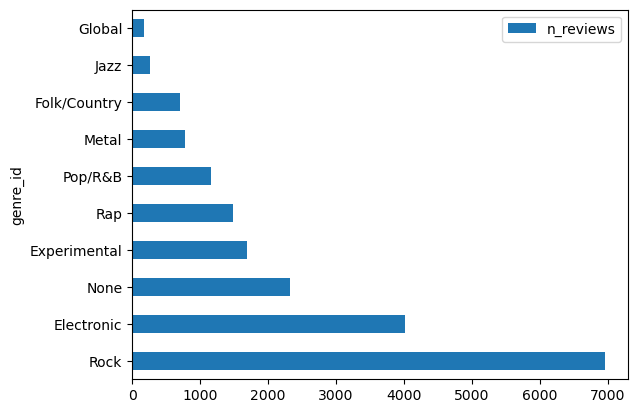

In [18]:
genres.plot.barh();

## The `album` table

In [19]:
albums = raw[['album','artist','genre']].value_counts().to_frame('n_reviews').reset_index().set_index(['artist','album'])
albums.index.names = ['artist_id','album_id']
albums = albums.rename(columns={'genre':'genre_id'})
albums.to_sql('album', db, index=True, if_exists='replace', index_label=albums.index.names)

19506

In [20]:
albums

,,genre_id,n_reviews
artist_id,album_id,,
NÙze,Songs on the Rocks,None,2
The Postal Service,Give Up,Electronic,2
Enon,Believo!,Rock,2
Tim Hecker,Radio Amor,Experimental,2
Of Montreal,"If He Is Protecting Our Nation, Then Who Will Protect Big Oil, Our Children?",Rock,2
...,...,...,...
Russian Circles,Guidance,Metal,1
Various Artists,Guess Who This Is: A Tribute to Dom Leone,None,1
Beck,Guerolito,Rock,1


## The `review` table

In [21]:
reviews = raw[['album', 'artist', 'best', 'date', 'review', 'score']].copy()
reviews.columns = ['album_id', 'artist_id', 'is_best', 'review_date', 'review_content', 'album_score']
reviews = reviews.set_index(['artist_id','album_id','review_date'])
reviews.to_sql('review', db, index=True, if_exists='replace', index_label=reviews.index.names)

19544

In [22]:
reviews.head()

,,,is_best,review_content,album_score
artist_id,album_id,review_date,,,
Wilco,A.M./Being There,December 6 2017,1,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
Hopsin,No Shame,December 6 2017,0,"On his corrosive fifth album, the rapper takes...",3.5
Glassjaw,Material Control,December 6 2017,0,"On their first album in 15 years, the Long Isl...",6.6
Nabihah Iqbal,Weighing of the Heart,December 6 2017,0,"On her debut LP, British producer Nabihah Iqba...",7.7
Neil Young / Promise of the Real,The Visitor,December 5 2017,0,"While still pointedly political, Neil Youngís ...",6.7


In [23]:
reviews.loc['Wilco'].sort_index()

,,is_best,review_content,album_score
album_id,review_date,,,
A Ghost Is Born,June 21 2004,0,At the time of Yankee Hotel Foxtrot's non-trad...,6.6
A.M./Being There,December 6 2017,1,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
Alpha Mike Foxtrot: Rare Tracks 1994ñ2014/What's Your 20? Essential Tracks 1994ñ2014,November 19 2014,0,1 / 2 Albums Both the†Alpha Mike Foxtrot†rarit...,7.0
Kicking Television: Live in Chicago,November 13 2005,0,This 2xCD live album finds the now six-piece b...,8.3
More Like the Moon EP,April 27 2003,0,"Okay, show of hands: how many of you people ha...",7.0
Schmilco,September 9 2016,0,Wilco's 10th album is a largely acoustic affai...,7.0
Sky Blue Sky,May 14 2007,0,Despite the experimental pedigree of their new...,5.2
Star Wars,July 23 2015,0,"With its $0 asking price, lawsuit-baiting titl...",7.7
Summerteeth,February 28 1999,0,After parting ways with Uncle Tupelo partner J...,9.4


In [24]:
reviews.loc['Wilco'].album_score.mean().round(2)

7.4

Note how the new `review` table has fewer columns -- e.g. we no longer have genre. 

# Results

So, we have create four primary tables from our raw data.

In [25]:
artists.head()

,n_reviews
artist_id,
Various Artists,717
Guided by Voices,25
David Bowie,22
Mogwai,21
The Beatles,21


In [26]:
albums.head()

,,genre_id,n_reviews
artist_id,album_id,,
NÙze,Songs on the Rocks,None,2
The Postal Service,Give Up,Electronic,2
Enon,Believo!,Rock,2
Tim Hecker,Radio Amor,Experimental,2
Of Montreal,"If He Is Protecting Our Nation, Then Who Will Protect Big Oil, Our Children?",Rock,2


In [27]:
genres.head()

,n_reviews
genre_id,
Rock,6954
Electronic,4020
None,2320
Experimental,1696
Rap,1481


In [28]:
reviews.head()

,,,is_best,review_content,album_score
artist_id,album_id,review_date,,,
Wilco,A.M./Being There,December 6 2017,1,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
Hopsin,No Shame,December 6 2017,0,"On his corrosive fifth album, the rapper takes...",3.5
Glassjaw,Material Control,December 6 2017,0,"On their first album in 15 years, the Long Isl...",6.6
Nabihah Iqbal,Weighing of the Heart,December 6 2017,0,"On her debut LP, British producer Nabihah Iqba...",7.7
Neil Young / Promise of the Real,The Visitor,December 5 2017,0,"While still pointedly political, Neil Youngís ...",6.7


# Use `.join()` 

If we want to see genre in the review, we can create a join.

In [29]:
reviews.join(albums)

is_best  \
artist_id      album_id                                  review_date                 
!!!            As If                                     October 21 2015         0   
               Jamie, My Intentions Are Bass EP          November 1 2010         0   
               Louden Up Now                             June 7 2004             0   
               Myth Takes                                March 2 2007            0   
               Shake the Shudder                         May 24 2017             0   
...                                                                            ...   
”lafur Arnalds Found Songs                               February 16 2010        0   
               Living Room Songs / Another Happy Day OST February 16 2012        0   
               Now I Am Winter                           April 9 2013            0   
”lˆf Arnalds   Innundir Skinni                           October 26 2010         0   
∆vangelist     Omen Ex Simulacra                         December 11 2013        0   

                                                                                                              review_content  \
artist_id      album_id                                  review_date                                                           
!!!            As If                                     October 21 2015   Despite popular perception, !!! never quite fi...   
               Jamie, My Intentions Are Bass EP          November 1 2010   The dance-rock fixtures enlist Bibio, Tim Gold...   
               Louden Up Now                             June 7 2004       For club-friendly artists to become or remain ...   
               Myth Takes                                March 2 2007      Nic Offer, now focused solely on this band aft...   
               Shake the Shudder                         May 24 2017       The new !!! album finds them working with a sl...   
...                                                                                                                      ...   
”lafur Arnalds Found Songs                               February 16 2010  The young Icelandic composer who has opened fo...   
               Living Room Songs / Another Happy Day OST February 16 2012  1 / 2 Albums The Icelandic composer, known for...   
               Now I Am Winter                           April 9 2013      The Icelandic composer who has toured with†Sig...   
”lˆf Arnalds   Innundir Skinni                           October 26 2010   Icelandic singer/songwriter continues to slowl...   
∆vangelist     Omen Ex Simulacra                         December 11 2013  On their second album Omen Ex Simulacra, the O...   

                                                                           album_score  \
artist_id      album_id                                  review_date                     
!!!            As If                                     October 21 2015           6.9   
               Jamie, My Intentions Are Bass EP          November 1 2010           6.8   
               Louden Up Now                             June 7 2004               7.0   
               Myth Takes                                March 2 2007              8.0   
               Shake the Shudder                         May 24 2017               7.3   
...                                                                                ...   
”lafur Arnalds Found Songs                               February 16 2010          6.3   
               Living Room Songs / Another Happy Day OST February 16 2012          4.5   
               Now I Am Winter                           April 9 2013              5.5   
”lˆf Arnalds   Innundir Skinni                           October 26 2010           8.0   
∆vangelist     Omen Ex Simulacra                         December 11 2013          7.0   

                                                                          genre_id  \
artist_id      album_id           

In [30]:
albums.join(artists, rsuffix='_artist')

,,genre_id,n_reviews,n_reviews_artist
artist_id,album_id,,,
NÙze,Songs on the Rocks,None,2,2
The Postal Service,Give Up,Electronic,2,3
Enon,Believo!,Rock,2,6
Tim Hecker,Radio Amor,Experimental,2,12
Of Montreal,"If He Is Protecting Our Nation, Then Who Will Protect Big Oil, Our Children?",Rock,2,20
...,...,...,...,...
Russian Circles,Guidance,Metal,1,6
Various Artists,Guess Who This Is: A Tribute to Dom Leone,None,1,717
Beck,Guerolito,Rock,1,11
